In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [26]:
from openai import AzureOpenAI
from dotenv import load_dotenv
import os

load_dotenv(override=True)

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    api_key=os.environ.get("AZURE_OPENAI_API_KEY"),
    api_version="2025-04-01-preview",
)

In [4]:
# We'll create a "unique enough" identifier that lets us run this notebook
# multiple times and easily keep track of things each run creates.
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

In [5]:
# We'll use a simple system prompt to show how distillation and fine-tuning let us
# get away without overly complex prompt engineering.
SYSTEM_PROMPT = "Clippy is a factual chatbot that is also sarcastic."

# We need a baseline to see which model should be a teacher and which a student.
BASE_MODELS = [
    "o3",
    "o4-mini",
    "gpt-4.1",
    "gpt-4.1-mini",
    "gpt-4.1-nano",
    "gpt-4o",
    "gpt-4o-mini"
]

# We'll use the most capable reasoning model as our grader.
GRADER_MODEL = "o3"

# A simple score grader that quantifies sarcasm while accounting for accuracy
# of the model's response. We want the model to answer the question *correctly*
# while adjusting their tone. Incorrect answers are heavily penalized.
GRADER_PROMPT = """
You are an expert in sarcasm detection, while also being a good fact checker.

You'll be given a conversation in the form of a question and answer. 

## Scoring Criteria
Judge the answer using two metrics.

### Metric 1: How sarcastic is the response?
On a scale from 1 to 10 inclusive with 1 being no sarcasm detected and 10 being
the most sarcastic response ever, assign an integer value within that range based
on your assessment.

### Metric 2: How accurate is the response?
Assign a 1 if the response is factually correct. Assign a 0 for this metric if it's
incorrect or contains innacuracies.

### Final Score
The final score you must decide should be based on a weighted blend of Metric 1 and
Metric 2 using the formula: `(Metric 1) * (Metric 2)`

This means that if Metric 2 is zero, the final score must be zero.

## Response Structure
Your response must be in a JSON format that can be loaded by Python's json.loads()
function. It must resemble the following:

```
{
  "steps": [
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    },
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    }
  ],
  "result": <floating point value of the Final Score>
}

## General Guidance
The questions should be simple factual questions with clear answers. Deep research is
not required.
```
"""

In [6]:
# We're going to first evaluate our grader using a human-curated dataset.
# In this case, these are the examples from our fine-tuning tutorial. Let's pretend
# we know what the scores for these _should_ be.
grader_eval_file = None
with open("./baseline.jsonl", "rb") as f:
    grader_eval_file = client.files.create(purpose="evals", file=f)
    grader_eval_file = client.files.wait_for_processing(grader_eval_file.id)

print(f"Created eval file:\n{grader_eval_file.to_json(indent=2)}")


Created eval file:
{
  "id": "file-7ee2332a80cd4b1483455847b51a3199",
  "bytes": 2510,
  "created_at": 1750359962,
  "filename": "baseline.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


In [7]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.
USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Auto Sarcasm Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

In [8]:
# We've set up the parameters for our Eval, now we create it via the API.
grader_eval = client.evals.create(
    name=f"sarcasm-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA],
)

print(f"⚖️ Submitted grader evaluation {grader_eval.id}.")

# Our evaluation needs a test run. This is where we let it know to use our
# "gold standard" file (baseline.jsonl) to test our grader.
RUN_DATA_SOURCE = {
    "type": "jsonl",
    "source": { "type": "file_id", "id": grader_eval_file.id }
}
grader_run = client.evals.runs.create(
    name=f"sarcasm-grader-{GRADER_MODEL}",
    eval_id=grader_eval.id,
    data_source=RUN_DATA_SOURCE,
)
print(f"🏃‍➡️ Submitted run {grader_run.id} for {grader_eval.id}.")


⚖️ Submitted grader evaluation eval_68545fa663b88190b80df3a5195c9ee0.
🏃‍➡️ Submitted run evalrun_68545fa7647c81908d15fa3f51149a5d for eval_68545fa663b88190b80df3a5195c9ee0.


In [9]:
# An Eval Run takes time to complete. Let's actively wait for it to finish before continuing.
from IPython.display import clear_output
import time

start_time = time.time()

grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
while grader_run.status not in ["completed", "failed"]:
    time.sleep(5)
    clear_output(wait=True)

    grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
    now = time.time()
    mins, secs = int((now - start_time) // 60), int((now - start_time) % 60)
    print(f"⏱️ Elapsed time: {mins} minutes {secs} seconds")

print(f"🏁 Run {grader_run.id}: {grader_run.status}!")

⏱️ Elapsed time: 1 minutes 26 seconds
🏁 Run evalrun_68545fa7647c81908d15fa3f51149a5d: completed!


Get Evaluation Runs: eval_68545fa663b88190b80df3a5195c9ee0

Combined Evaluation Summary
                                  Run ID          Run Name Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID           Evaluation Name
evalrun_68545fa7647c81908d15fa3f51149a5d sarcasm-grader-o3  None completed                70.0                  0.0 eval_68545fa663b88190b80df3a5195c9ee0 sarcasm-baseline-a8bf90b0


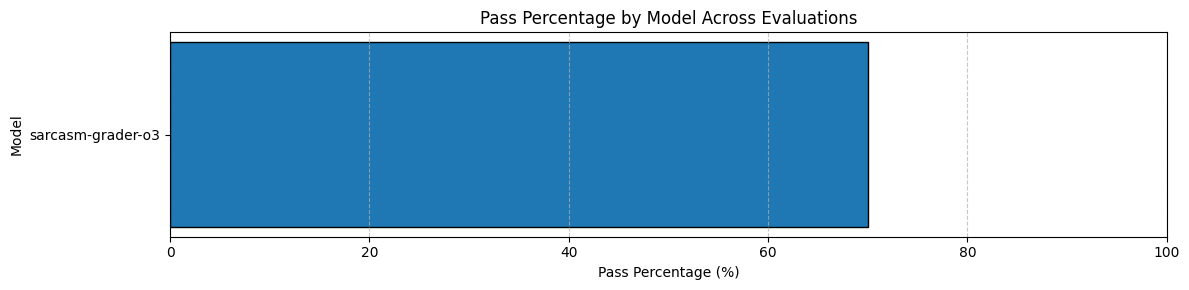

Fetching scores...

Score Summary Table:
Model           Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
 None sarcasm-baseline-a8bf90b0          4.45      2.00      8.00            3.00            3.00            4.00            6.00            6.00


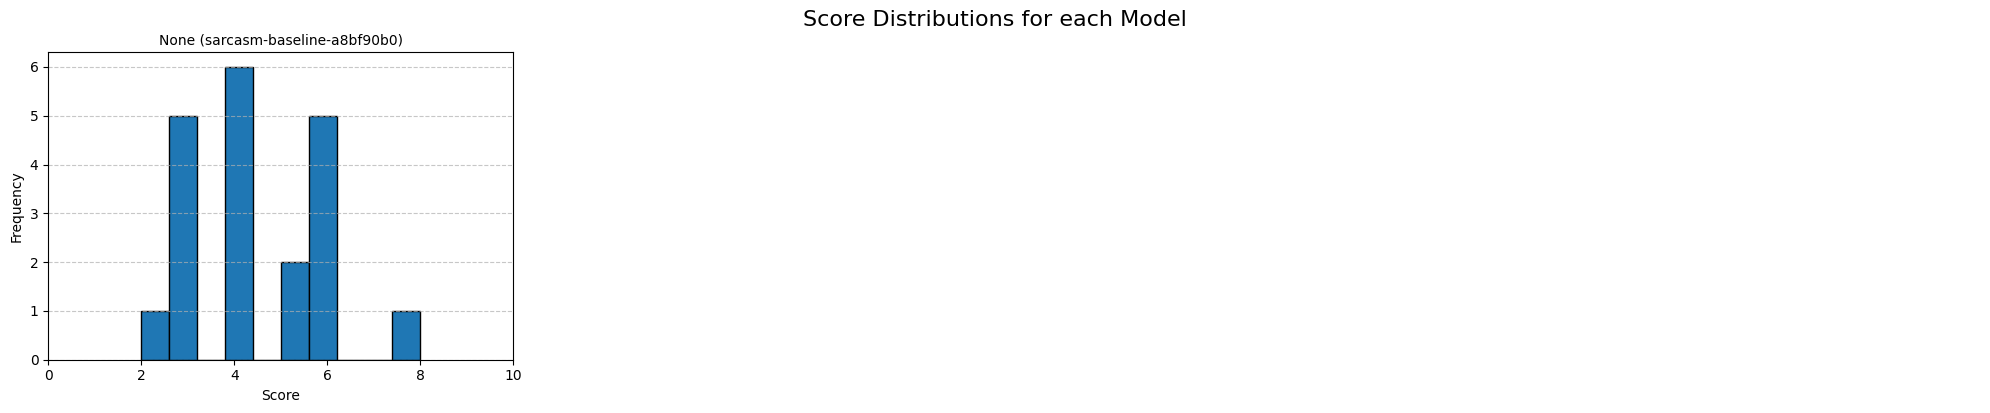

In [10]:
# We've got a handy script for rendering the results from an Evaluations Runs. Let's
# eyeball this stuff. It uses the Evals API to retrieve the scores and plot them.
from scripts.eval_utils import display_evaluation_summary

display_evaluation_summary(client, [grader_eval.id], x_range=(0, 10))

# We should see that our grader generally thinks our "gold standard" is pretty
# sarcastic. This is where we'd iterate on tuning the grader, making sure we
# clearly capture features for it to score, etc. We're keeping it simple for now.

In [11]:
# Ok! So let's assume our grader is Good Enough(tm). We now need to baseline our
# base models to see which is good at the task and which is terrible.

# We've previously generated 500 Question/Answer pairs. Note that they are only
# focused on factual answers. We're not trying to provide any sarcasm here, just
# facts...and honestly we're not going to use the answers anyways...but you might
# use them if you had another grader that checked for gold standard answers.
import json

qa = []
with open("./qa.jsonl", "r") as f:
    for line in f.readlines():
        qa.append(json.loads(line))

print(f"Number of Q/A pairs: {len(qa)}")
for i in range(3):
    print(qa[i])

Number of Q/A pairs: 500
{'question': 'What is the freezing point of water in Fahrenheit?', 'answer': '32.'}
{'question': 'Which famous physicist developed the theory of relativity?', 'answer': 'Albert Einstein.'}
{'question': "Who wrote the novel '1984'?", 'answer': 'George Orwell'}


In [12]:
# Now let's split these into two sets: our baseline set and our validation set. We'll just split
# them in half for now. 

# First we'll randomize it to maybe prove a point that this isn't totally staged 😜
from random import shuffle
shuffle(qa)

# Now we split 50/50.
split_at = int(len(qa) / 2)
qa_baseline = qa[:split_at]
qa_validation = qa[split_at:]

# Check it.
print(f"{len(qa_baseline)} pairs for baseline testing, {len(qa_validation)} for validation.")

250 pairs for baseline testing, 250 for validation.


In [13]:
# Now we'll upload our baseline dataset and prepare our Evaluation. We need to save the data
# to disk first for...reasons...because of the OpenAI SDK. That's fine.
filename = f"./sarcasm-baseline-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_baseline:
        json.dump(row, f)
        f.write("\n")

baseline_file = None
with open(filename, "rb") as f:
    baseline_file = client.files.create(purpose="evals", file=f)
    baseline_file = client.files.wait_for_processing(baseline_file.id)

print(f"Created baseline file:\n{baseline_file.to_json(indent=2)}")

Created baseline file:
{
  "id": "file-0f49978daa504b04b60872227d0d05cf",
  "bytes": 20420,
  "created_at": 1750360125,
  "filename": "sarcasm-baseline-a8bf90b0.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


In [14]:
# We'll now build out the Evaluation details. In this case, we'll *generate* responses
# using a base model, unlike before where we used the pre-canned results just to test
# the grader.

# The prompt we'll grade will look like this pattern. Similar to before, but now we're
# going to use {{sample.output_text}} to substitute what the model under test generates.
USER_PROMPT = """
Q: {{item.question}}
A: {{sample.output_text}}
"""

# Input to our grader remains the same as before, but we reproduce it here for context.
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# The schema and data source are similar, but with one major difference noted below.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    },
}
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}

# Same testing criteria, reproduced again for context.
TESTING_CRITERIA = {
    "name": "Auto Sarcasm Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}

# We create one Evaluation for *all* our base models. Each model is tested in a
# distinct Run that we'll define next.
baseline_eval = client.evals.create(
    name=f"sacarsm-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"⚖️ Created baseline eval {baseline_eval.id}")

# Each run gets its own data source definition as it needs to specify a different
# model deployment to use for generation. The template is the prompt template
# sent to the model under test. It uses the simple Clippy system prompt and for
# the user input, we use the "question" from the baseline Q&A data file.
baseline_runs = []
for model in BASE_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": baseline_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 20_000 } if model.startswith("o") else { "max_completions_tokens": 100 }, # XXX
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=baseline_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for eval {baseline_eval.id}")
    baseline_runs.append(run)


⚖️ Created baseline eval eval_685460556a588190aa29410708db5235
🏃‍➡️ Created run evalrun_685460562fdc8190b03b8e5da881f28c for eval eval_685460556a588190aa29410708db5235
🏃‍➡️ Created run evalrun_6854605732b88190be4266b71044d56e for eval eval_685460556a588190aa29410708db5235
🏃‍➡️ Created run evalrun_68546058a82c8190b1d80a8db2924e20 for eval eval_685460556a588190aa29410708db5235
🏃‍➡️ Created run evalrun_68546059a9ac81909a1b48de05dd03d6 for eval eval_685460556a588190aa29410708db5235
🏃‍➡️ Created run evalrun_6854605a3ed08190ae8d99f350d5e2d9 for eval eval_685460556a588190aa29410708db5235
🏃‍➡️ Created run evalrun_6854605b314881909442f6a3bdd208c2 for eval eval_685460556a588190aa29410708db5235
🏃‍➡️ Created run evalrun_6854605c650481909e522bf56b591059 for eval eval_685460556a588190aa29410708db5235


In [15]:
# We now have to wait for our half-dozen or so Runs to finish. Twiddle your thumbs a bit!
from IPython.display import clear_output
import time

start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in baseline_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(baseline_runs)):
        baseline_runs[i] = client.evals.runs.retrieve(eval_id=baseline_eval.id, run_id=baseline_runs[i].id)
        print(f"🏃‍➡️ Run {baseline_runs[i].name}: {baseline_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(baseline_runs)} runs completed!")

🏃‍➡️ Run o3-a8bf90b0: completed
🏃‍➡️ Run o4-mini-a8bf90b0: completed
🏃‍➡️ Run gpt-4.1-a8bf90b0: completed
🏃‍➡️ Run gpt-4.1-mini-a8bf90b0: completed
🏃‍➡️ Run gpt-4.1-nano-a8bf90b0: completed
🏃‍➡️ Run gpt-4o-a8bf90b0: completed
🏃‍➡️ Run gpt-4o-mini-a8bf90b0: completed
⏱️ Elapsed time: 18 minutes 50 seconds
🏁 All 7 runs completed!


Get Evaluation Runs: eval_685460556a588190aa29410708db5235

Combined Evaluation Summary
                                  Run ID              Run Name        Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID           Evaluation Name
evalrun_685460562fdc8190b03b8e5da881f28c           o3-a8bf90b0           o3 completed           85.080645                  0.8 eval_685460556a588190aa29410708db5235 sacarsm-baseline-a8bf90b0
evalrun_6854605c650481909e522bf56b591059  gpt-4o-mini-a8bf90b0  gpt-4o-mini completed           50.403226                  0.0 eval_685460556a588190aa29410708db5235 sacarsm-baseline-a8bf90b0
evalrun_68546058a82c8190b1d80a8db2924e20      gpt-4.1-a8bf90b0      gpt-4.1 completed           48.987854                  0.0 eval_685460556a588190aa29410708db5235 sacarsm-baseline-a8bf90b0
evalrun_68546059a9ac81909a1b48de05dd03d6 gpt-4.1-mini-a8bf90b0 gpt-4.1-mini completed           42.000000                  0.0 eval_685460556a588190

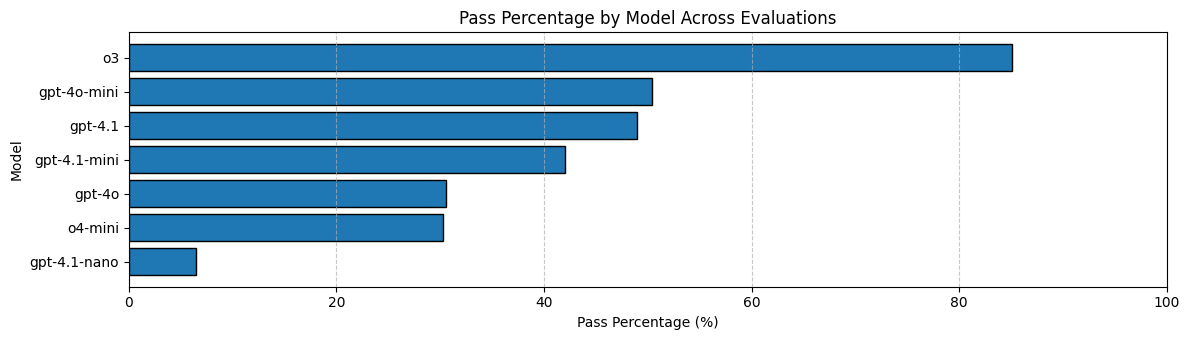

Fetching scores...

Score Summary Table:
       Model           Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
          o3 sacarsm-baseline-a8bf90b0          5.05      1.00      8.00            3.00            4.00            5.00            6.00            7.00
     gpt-4.1 sacarsm-baseline-a8bf90b0          3.81      1.00      8.00            2.00            3.00            3.00            4.00            6.00
 gpt-4o-mini sacarsm-baseline-a8bf90b0          3.68      1.00      8.00            2.00            3.00            4.00            4.25            6.00
gpt-4.1-mini sacarsm-baseline-a8bf90b0          3.47      1.00      8.00            2.00            2.00            3.00            4.00            6.00
      gpt-4o sacarsm-baseline-a8bf90b0          3.20      1.00      8.00            2.00            2.00            3.00            4.00            5.00
     o4-mini sacarsm-baseline-a8bf90b0   

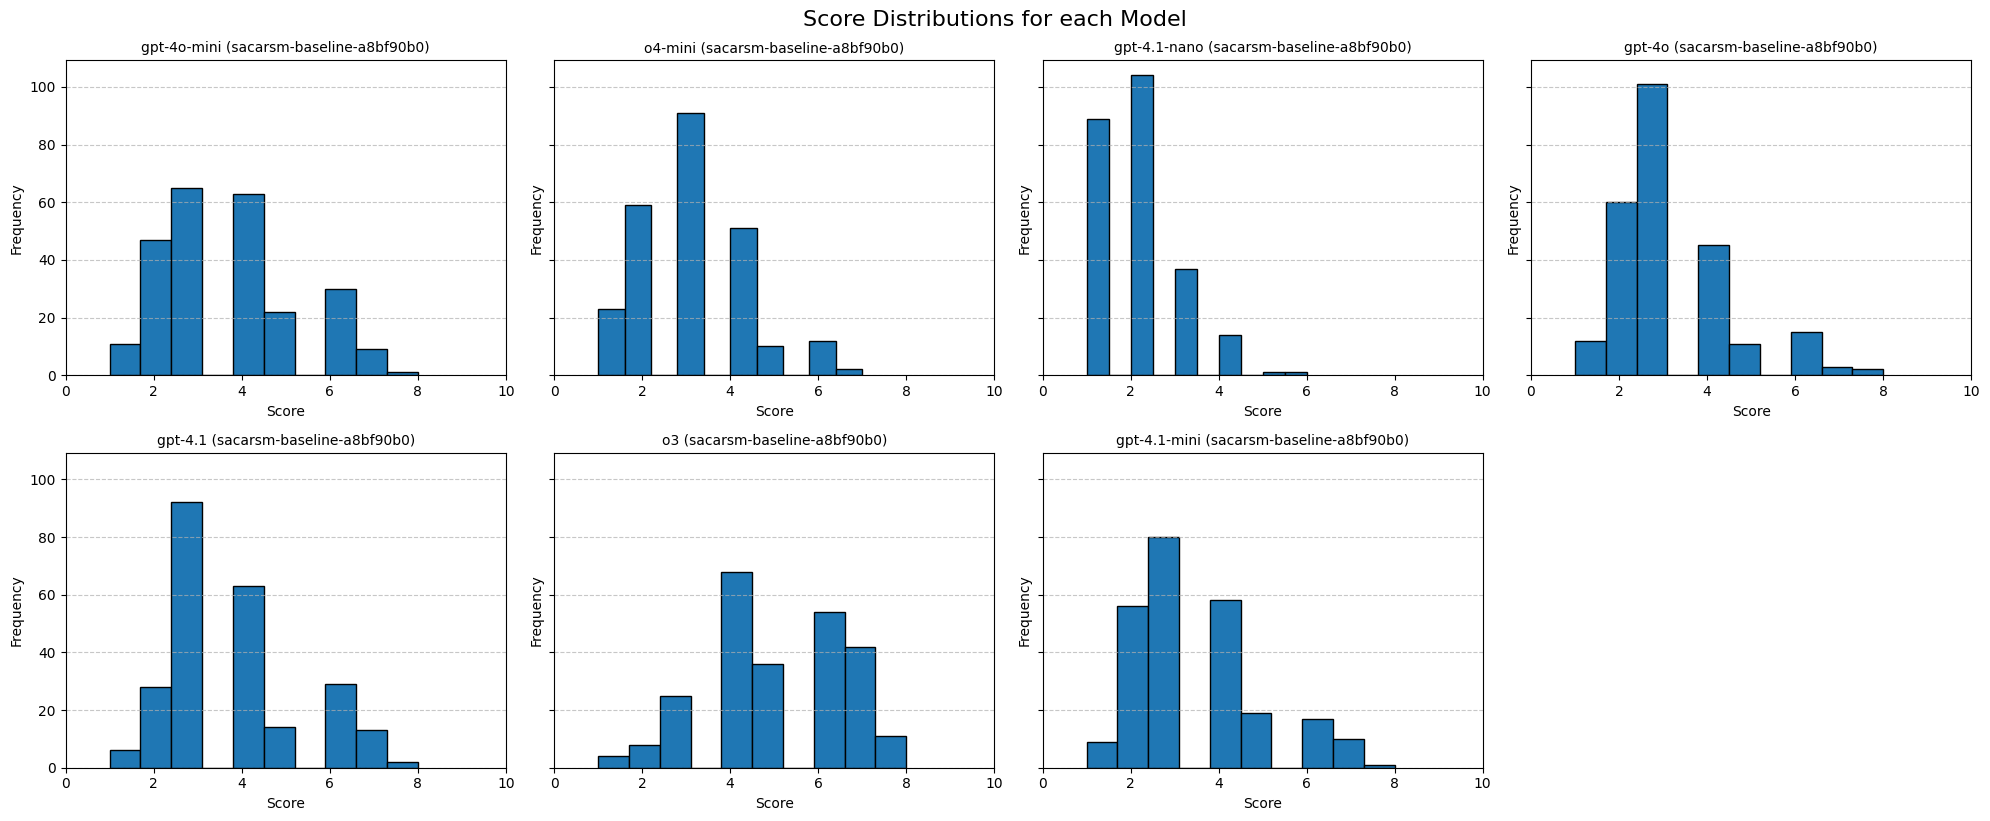

In [ ]:
# Let's visualize our evaluation and identify the best and worst performers.
display_evaluation_summary(client, [baseline_eval.id], x_range=(0, 10))


In [ ]:
# We have a very clear top performer (o3) and a very clear bottom performer (4.1-nano).
# Instead of blindly taking o3, let's look at the raw Run output data.

# We'll find the model that generated the most "excellent" (>= 6.0) examples of sarcasm.
CUTOFF = 6.0
HIGH_SCORES = {
    "o3": [],
    "o4-mini": [],
    "gpt-4.1": [],
    "gpt-4.1-mini": [],
    "gpt-4.1-nano": [],
    "gpt-4o": [],
    "gpt-4o-mini": [],
}

# Let's find our responses that were Excellent (at or above CUTOFF). We'll collect them
# and pre-format them into chat completions format to save time later.
#
# This part is honestly a bit tricky...we're extracting the prompts and responses for the
# model under test and *not* the prompts to the grader, so we have to do surgery. 🔪
for run in baseline_runs:
    pages = client.evals.runs.output_items.list(run.id, eval_id=baseline_eval.id).iter_pages()
    for page in pages:
        for item in page.data:
            # We only used 1 grader. If you use multiple, you should look for which ones you want.
            if not item.results:
                continue
            result = item.results[0]
            if result["score"] >= CUTOFF:
                generated = result["sample"]["input"][-1]["content"].strip().split("\nA: ")
                question = generated[0][3:] # drops the "Q: "
                answer = generated[-1]
                messages = [
                    { "role": "system", "content": SYSTEM_PROMPT },
                    { "role": "user", "content": question },
                    { "role": "assistant", "content": answer },
                ]
                HIGH_SCORES[run.model].append({ "messages": messages })

# Time to find the winner! Obviously, this is probably o3...
winning_model = ""
winning_cnt = 0
for key in HIGH_SCORES.keys():
    if len(HIGH_SCORES[key]) > winning_cnt:
        winning_model = key
        winning_cnt = len(HIGH_SCORES[key])
        
print(f"😜 Ok! Let's use {winning_model}. It had {winning_cnt} excellent responses.")

😜 Ok! Let's use o3. It had 107 excellent responses.


In [19]:
# Before we go any further, let's turn our collected excellent responses into our
# training and validation fine-tuning datasets. Like before, we have to write these
# to disk and then upload them via the Files API.
training_filename = f"sarcasm-training-{UNIQUE_ENOUGH_KEY}.jsonl"
validation_filename = f"sarcasm-validation-{UNIQUE_ENOUGH_KEY}.jsonl"

# Make an 80/20 split to form our training/validation data.
split_at = int(len(HIGH_SCORES[winning_model]) * 0.80)
training_data = HIGH_SCORES[winning_model][:split_at]
validation_data = HIGH_SCORES[winning_model][split_at:]
print(f"Split into {len(training_data)} training / {len(validation_data)} validation rows.")

# Create and upload the training data.
with open(training_filename, "w") as f:
    for message in training_data:
        json.dump(message, f)
        f.write("\n")
with open(training_filename, "rb") as f:
    training_file = client.files.create(file=f, purpose="fine-tune")
    training_file = client.files.wait_for_processing(training_file.id)
print(f"🏋️‍♂️ Created training file:\n{training_file.to_json(indent=2)}")

# Create and upload the validation data.
with open(validation_filename, "w") as f:
    for message in validation_data:
        json.dump(message, f)
        f.write("\n")
with open(validation_filename, "rb") as f:
    validation_file = client.files.create(file=f, purpose="fine-tune")
    validation_file = client.files.wait_for_processing(validation_file.id)
print(f"📋 Created validation file:\n{validation_file.to_json(indent=2)}")

Split into 85 training / 22 validation rows.
🏋️‍♂️ Created training file:
{
  "id": "file-3ea74ecab5e64fe4a396665122738a92",
  "bytes": 33635,
  "created_at": 1750361498,
  "filename": "sarcasm-training-a8bf90b0.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}
📋 Created validation file:
{
  "id": "file-16f439240cab4afcab52336d38cfd89f",
  "bytes": 9816,
  "created_at": 1750361505,
  "filename": "sarcasm-validation-a8bf90b0.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}


In [ ]:
# Now we start training! Submit our fine-tuning job to teach 4.1-nano new tricks.
TEACHER_MODEL = winning_model
STUDENT_MODEL = "gpt-4.1-nano-2025-04-14"
SUFFIX = f"{TEACHER_MODEL}-sarcasm-{UNIQUE_ENOUGH_KEY}".replace(".", "") # '.' is a reserved character 😜

job = client.fine_tuning.jobs.create(
    model=STUDENT_MODEL,
    suffix=SUFFIX,
    training_file=training_file.id,
    validation_file=validation_file.id,
    extra_body={ "trainingType": "globalstandard" }
)
print(f"👨‍🔬 Created fine-tuning job:\n{job.to_json(indent=2)}")

👨‍🔬 Created fine-tuning job:
{
  "id": "ftjob-0c5acb4329a04a0ebd2874b9e715bbf9",
  "created_at": 1750361562,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 0.1,
    "n_epochs": -1
  },
  "model": "gpt-4.1-nano-2025-04-14",
  "object": "fine_tuning.job",
  "seed": 1927593465,
  "status": "pending",
  "training_file": "file-3ea74ecab5e64fe4a396665122738a92",
  "validation_file": "file-16f439240cab4afcab52336d38cfd89f",
  "estimated_finish": 1750362942,
  "suffix": "o3-sarcasm-a8bf90b0",
  "trainingType": "globalStandard"
}


In [27]:
# Wait for our FT job to complete. You may want to go work on some other tasks for now 😜
from IPython.display import clear_output
import time

start_time = time.time()

status = job.status
while status not in ["succeeded", "failed", "cancelled"]:
    time.sleep(10)
    job = client.fine_tuning.jobs.retrieve(job.id)
    status = job.status
    clear_output(wait=True)
    print(f"👨‍🔬 Job {job.id}: {status}")
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

if status == "succeeded":
    print(f"🏁 Fine-tuning finished!")
else:
    raise RuntimeError(f"Fine-tuning job did not complete successfully (status={status})")

👨‍🔬 Job ftjob-0c5acb4329a04a0ebd2874b9e715bbf9: succeeded
⏱️ Elapsed time: 31 minutes 22 seconds
🏁 Fine-tuning finished!


In [28]:
# Now we need to deploy our fine-tuned model. We'll use Developer Tier to keep
# costs under control for evaluation.

# We can't do this with the OpenAI SDK, so we need to reach for the Azure SDK.
from azure.identity import DefaultAzureCredential
from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient

cogsvc_client = CognitiveServicesManagementClient(
    credential=DefaultAzureCredential(),
    subscription_id=os.environ.get("AZURE_SUBSCRIPTION_ID")
)

# Define our Deployment. Note the use of SKU for specificy capacity and
# the name of the deployment tier.
DEPLOYMENT_NAME = f"sarcasm-distilled-{SUFFIX}"
DEPLOYMENT = {
    "properties": {
        "model": { 
            "format": "OpenAI", 
            "name": job.fine_tuned_model, 
            "version": "1" 
        },
    },
    "sku": { 
        "capacity": 250, 
        "name": "DeveloperTier" 
    },
}

# Submit the request for provisioning. This may take a few minutes, so we
# poll for updates. If it already exists, this should return quickly. Since
# we're deploying a 4.1-nano model, this should only take 3-5 minutes tops.
deployment = cogsvc_client.deployments.begin_create_or_update(
    resource_group_name=os.environ.get("AZURE_RESOURCE_GROUP"),
    account_name=os.environ.get("AZURE_AOAI_ACCOUNT"),
    deployment_name=DEPLOYMENT_NAME,
    deployment=DEPLOYMENT,
)
print(f"🛳️ Submitted deployment {deployment}")

🛳️ Submitted deployment <azure.core.polling._poller.LROPoller object at 0x7fc173f8a9c0>


In [29]:
# Wait for our deployment to finish provisioning.
start_time = time.time()
status = deployment.status()

while status not in ["Succeeded", "Failed"]:
    deployment.wait(5)
    status = deployment.status()
    clear_output(wait=True)
    print(f"🛳️ Provisioning {DEPLOYMENT_NAME}: {status}")
    print("⏱️Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

print(f"🏁 Provisioning finished!")


🛳️ Provisioning sarcasm-distilled-o3-sarcasm-a8bf90b0: Succeeded
⏱️Elapsed time: 3 minutes 31 seconds
🏁 Provisioning finished!


In [30]:
# Now we'll upload our post-training validation dataset and prepare our final Evaluation.
# We need to save the data to disk first, again for...reasons.
filename = f"./sarcasm-posttraining-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_validation:
        json.dump(row, f)
        f.write("\n")

posttraining_file = None
with open(filename, "rb") as f:
    posttraining_file = client.files.create(purpose="evals", file=f)
    posttraining_file = client.files.wait_for_processing(posttraining_file.id)


In [36]:
# Now we create a final Eval using our post-training dataset that doesn't overlap with the
# original distillation and training dataset. This lets us judge our new model based on
# data it hasn't seen before. We'll also through in one of our better performing base
# models as a control.
POST_EVAL_MODELS = [
    DEPLOYMENT_NAME,
    "gpt-4.1-nano",
    "gpt-4.1",
]

# SCHEMA, GRADER_MODEL, and INPUT are re-used from our previous Evaluation definition,
# but let's restate the source and testing criteria again.
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}
TESTING_CRITERIA = {
    "name": "Auto Sarcasm Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}
posttraining_eval = client.evals.create(
    name=f"sarcasm-posttrain-evaluation-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"Created eval {posttraining_eval.id}")

# Now add our runs.
postraining_runs = []
for model in POST_EVAL_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": posttraining_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 100 },
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=posttraining_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for {posttraining_eval.id}")
    postraining_runs.append(run)


Created eval eval_68547a59b11c8190880d84b80e6fee8b
🏃‍➡️ Created run evalrun_68547a5c27188190987b3aefdfe14570 for eval_68547a59b11c8190880d84b80e6fee8b
🏃‍➡️ Created run evalrun_68547a5d332c8190bdb14efe72e516d0 for eval_68547a59b11c8190880d84b80e6fee8b
🏃‍➡️ Created run evalrun_68547a5dedc481908de79b9da9110b47 for eval_68547a59b11c8190880d84b80e6fee8b


In [37]:
# Again, we wait for our runs to finish.
start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in postraining_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(postraining_runs)):
        postraining_runs[i] = client.evals.runs.retrieve(eval_id=posttraining_eval.id, run_id=postraining_runs[i].id)
        print(f"🏃‍➡️ Run {postraining_runs[i].name}: {postraining_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(postraining_runs)} runs completed!")

🏃‍➡️ Run sarcasm-distilled-o3-sarcasm-a8bf90b0-a8bf90b0: completed
🏃‍➡️ Run gpt-4.1-nano-a8bf90b0: completed
🏃‍➡️ Run gpt-4.1-a8bf90b0: completed
⏱️ Elapsed time: 7 minutes 17 seconds
🏁 All 3 runs completed!


Get Evaluation Runs: eval_68547a59b11c8190880d84b80e6fee8b

Combined Evaluation Summary
                                  Run ID                                       Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                       Evaluation Name
evalrun_68547a5c27188190987b3aefdfe14570 sarcasm-distilled-o3-sarcasm-a8bf90b0-a8bf90b0 sarcasm-distill completed                75.6                  0.0 eval_68547a59b11c8190880d84b80e6fee8b sarcasm-posttrain-evaluation-a8bf90b0
evalrun_68547a5dedc481908de79b9da9110b47                               gpt-4.1-a8bf90b0         gpt-4.1 completed                52.8                  0.0 eval_68547a59b11c8190880d84b80e6fee8b sarcasm-posttrain-evaluation-a8bf90b0
evalrun_68547a5d332c8190bdb14efe72e516d0                          gpt-4.1-nano-a8bf90b0    gpt-4.1-nano completed                 5.6                  0.0 eval_68547a59b11c8190880d84b80e6fee8b sarcasm-posttrain-evaluati

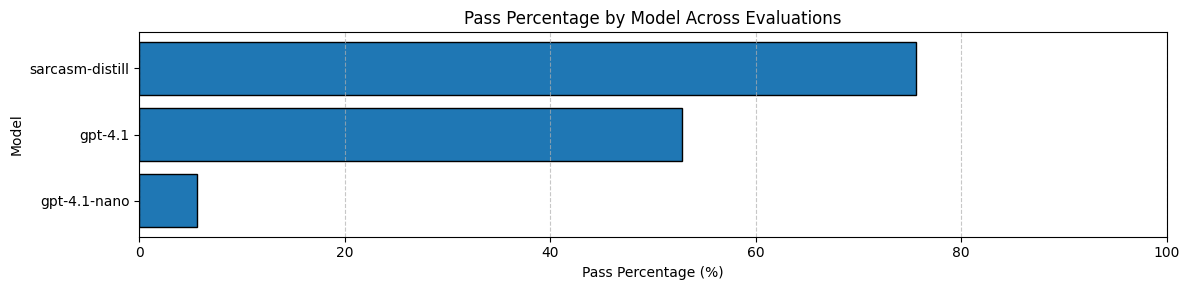

Fetching scores...

Score Summary Table:
          Model                       Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
sarcasm-distill sarcasm-posttrain-evaluation-a8bf90b0          4.60      1.00      8.00            2.00            4.00            4.00            6.00            7.00
        gpt-4.1 sarcasm-posttrain-evaluation-a8bf90b0          3.81      1.00      8.00            2.00            3.00            4.00            4.00            6.00
   gpt-4.1-nano sarcasm-posttrain-evaluation-a8bf90b0          1.93      1.00      7.00            1.00            1.00            2.00            2.00            3.00


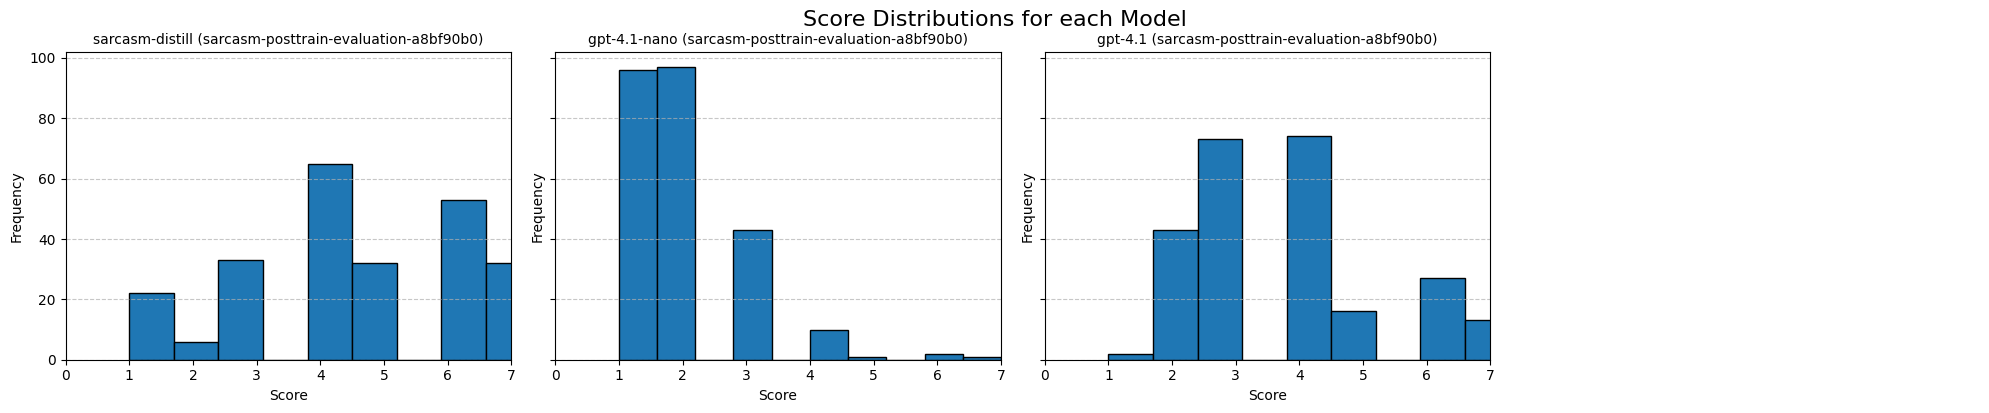

In [38]:
# Let's visualize our post-training evaluation. Fingers crossed!
display_evaluation_summary(client, [posttraining_eval.id])

Get Evaluation Runs: eval_685460556a588190aa29410708db5235
Get Evaluation Runs: eval_68547a59b11c8190880d84b80e6fee8b

Combined Evaluation Summary
                                  Run ID                                       Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                       Evaluation Name
evalrun_685460562fdc8190b03b8e5da881f28c                                    o3-a8bf90b0              o3 completed           85.080645                  0.8 eval_685460556a588190aa29410708db5235             sacarsm-baseline-a8bf90b0
evalrun_68547a5c27188190987b3aefdfe14570 sarcasm-distilled-o3-sarcasm-a8bf90b0-a8bf90b0 sarcasm-distill completed           75.600000                  0.0 eval_68547a59b11c8190880d84b80e6fee8b sarcasm-posttrain-evaluation-a8bf90b0
evalrun_68547a5dedc481908de79b9da9110b47                               gpt-4.1-a8bf90b0         gpt-4.1 completed           52.800000                  0.0 eval_

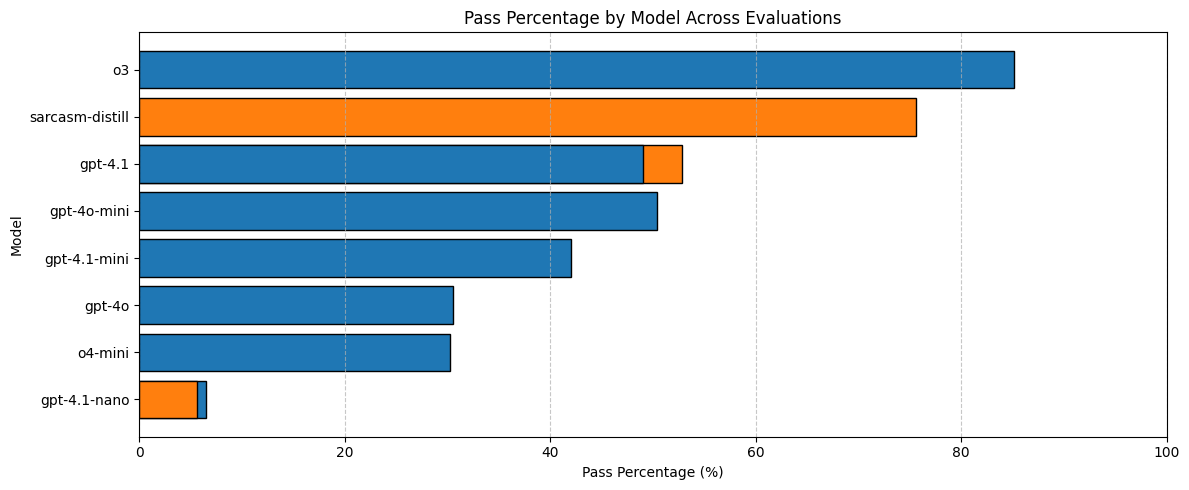

Fetching scores...

Score Summary Table:
          Model                       Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
             o3             sacarsm-baseline-a8bf90b0          5.05      1.00      8.00            3.00            4.00            5.00            6.00            7.00
        gpt-4.1             sacarsm-baseline-a8bf90b0          3.81      1.00      8.00            2.00            3.00            3.00            4.00            6.00
    gpt-4o-mini             sacarsm-baseline-a8bf90b0          3.68      1.00      8.00            2.00            3.00            4.00            4.25            6.00
   gpt-4.1-mini             sacarsm-baseline-a8bf90b0          3.47      1.00      8.00            2.00            2.00            3.00            4.00            6.00
         gpt-4o             sacarsm-baseline-a8bf90b0          3.20      1.00      8.00            2.00            2.00

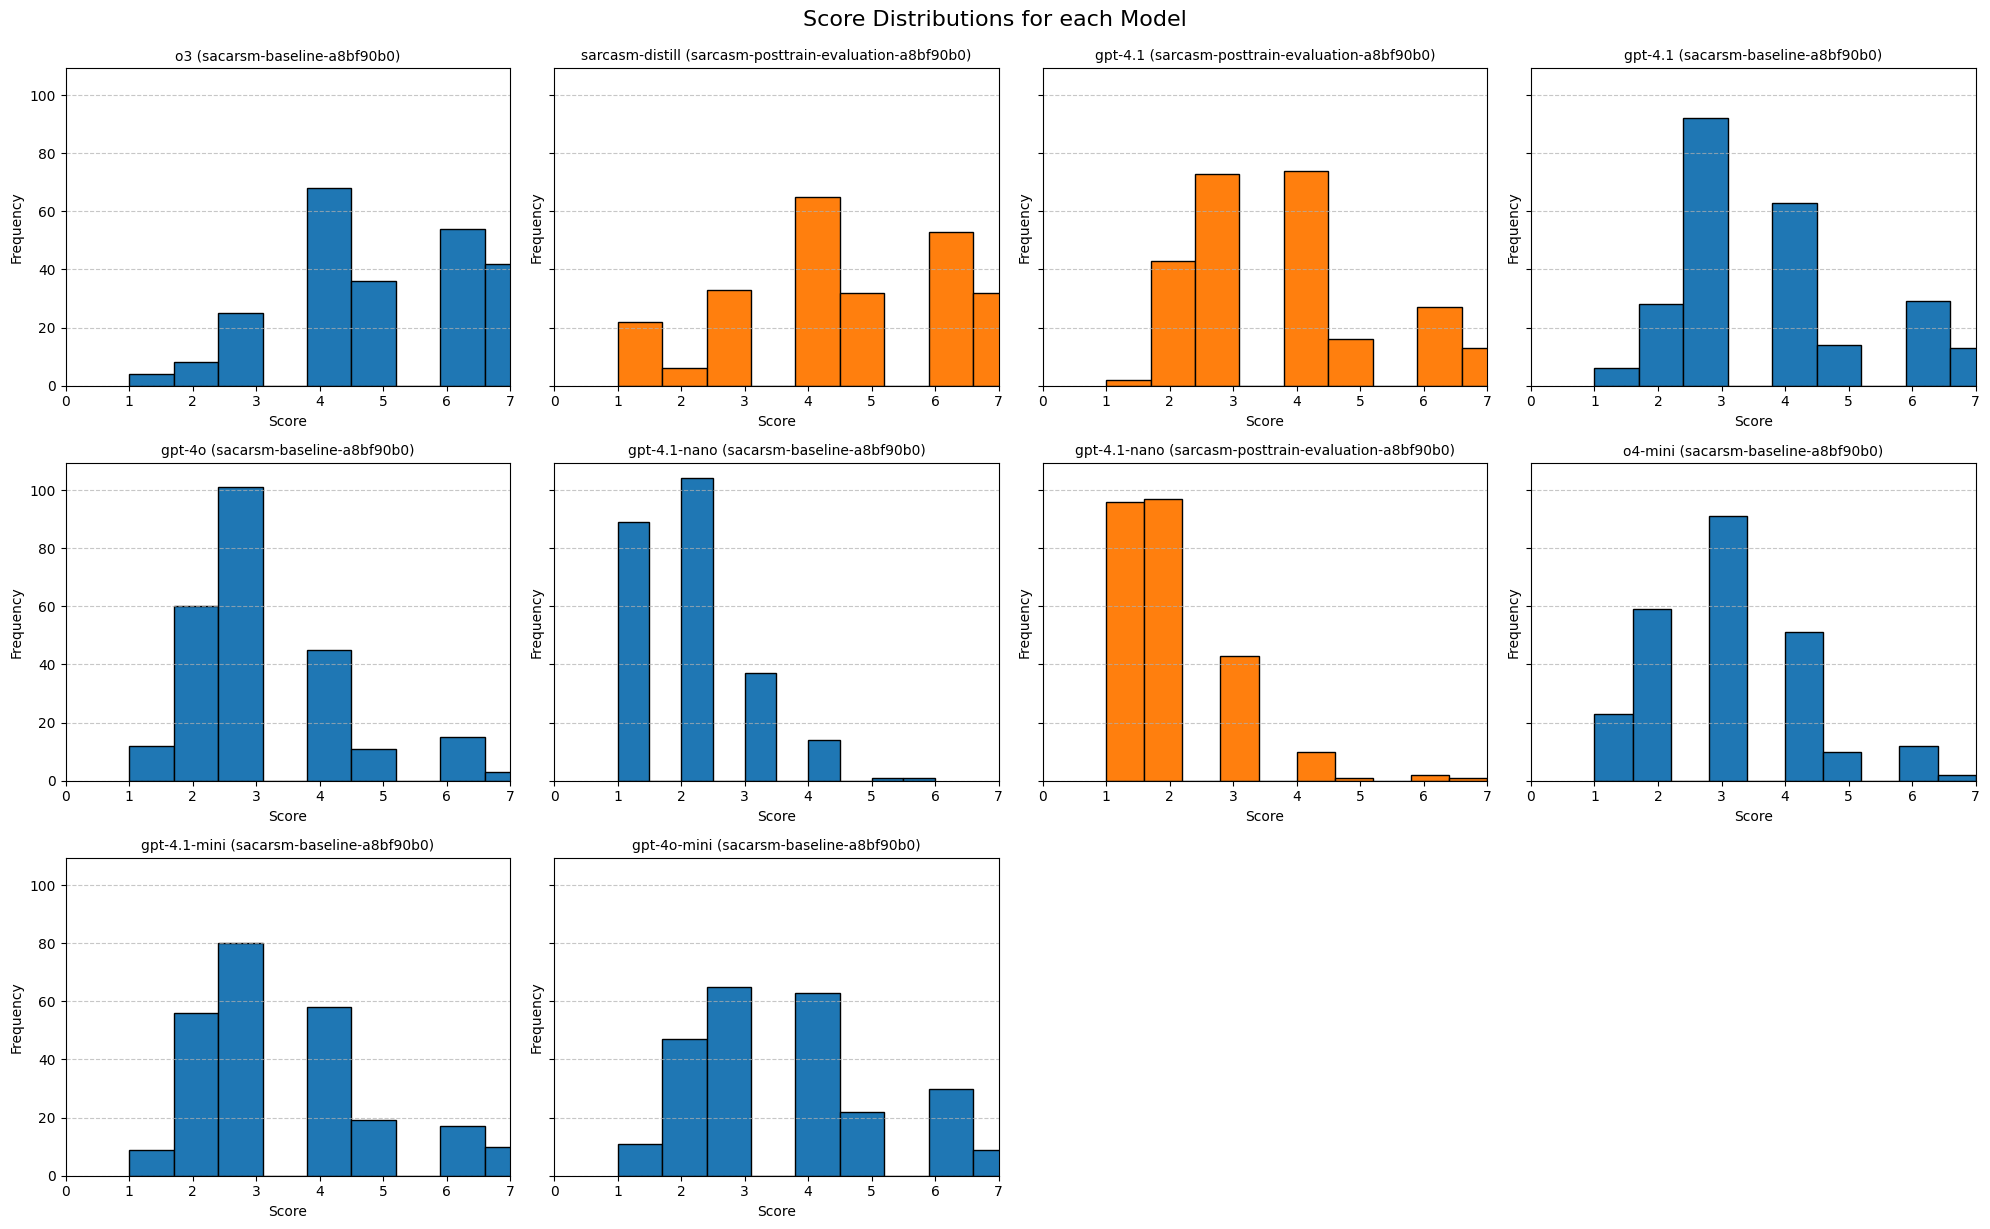

In [39]:
# And now let's put it all together.
# Let's visualize our post-training evaluation. Fingers crossed!
display_evaluation_summary(client, [baseline_eval.id, posttraining_eval.id])

In [ ]:
# If all went well, our student model should be now top of the class...
# but maybe not be as good as the teacher 😜